# Practice Session 09: Forecasting


Author: <font color="white">Mario Muñoz Serrano</font>

Date: <font color="white">05/12/2022</font>

In [3]:
import io
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# 1. Dataset

In [4]:
# LEAVE AS-IS

INPUT_FILE = "https://raw.githubusercontent.com/mariomunooz/data/main/aemet-barcelona-airport-2016-2022.json"
weather = pd.read_json(INPUT_FILE)

weather.head(5)

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN
3,2016-07-04,0201D,BARCELONA,BARCELONA,6,"23,8","0,0","21,8",04:40,"25,9",10:30,25.0,"3,3","6,7",23:20,NaN,NaN,NaN,NaN,NaN
4,2016-07-05,0201D,BARCELONA,BARCELONA,6,"25,3","0,0","23,2",00:10,"27,4",14:00,35.0,"3,1","6,4",02:00,NaN,NaN,NaN,NaN,NaN


In [5]:
# LEAVE AS-IS

COLUMN_NAMES = {
  "fecha" : "date",
  "indicativo" : "station_num",
  "nombre" : "station_name",
  "provincia" : "station_province",
  "altitud" : "station_altitude",
  "tmed" : "temp_avg",
  "tmin" : "temp_min",
  "tmax" : "temp_max",
  "horatmin" : "time_temp_min",
  "horatmax" : "time_temp_max",
  "prec" : "rainfall",
  "dir" : "windspeed_dir",
  "velmedia" : "windspeed_avg",
  "racha" : "windspeed_gusts",
  "horaracha" : "time_windspeed_gusts",
  "sol" : "sun",
  "presMax" : "pressure_max",
  "horaPresMax" : "time_pressure_max",
  "presMin" : "pressure_min",
  "horaPresMin" : "time_pressure_min"
}

In [6]:
# code to rename column names, and print the first 3 rows of the data
weather = weather.rename(mapper = COLUMN_NAMES, axis = 1)
weather.head(3)

,date,station_num,station_name,station_province,station_altitude,temp_avg,rainfall,temp_min,time_temp_min,temp_max,time_temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,time_windspeed_gusts,sun,pressure_max,time_pressure_max,pressure_min,time_pressure_min
0,2016-07-01,0201D,BARCELONA,BARCELONA,6,"24,1","0,0","21,9",03:40,"26,3",11:50,99.0,"3,1","5,8",10:50,NaN,NaN,NaN,NaN,NaN
1,2016-07-02,0201D,BARCELONA,BARCELONA,6,"24,6","0,0","22,3",04:40,"27,0",11:50,13.0,"3,6","7,5",12:10,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,0201D,BARCELONA,BARCELONA,6,"23,4","0,0","21,9",11:00,"24,9",08:10,20.0,"4,2","8,9",08:50,NaN,NaN,NaN,NaN,NaN


In [7]:
# code to drop the station_num, station_name, station_province, 
# station_altitude, and time_* columns, which we will not use, 
# and print the first 3 rows of the data
cols_to_drop = list(weather.filter(regex='station_'))
cols_to_drop.extend(list(weather.filter(regex='time_')))

weather = weather.drop(labels= cols_to_drop, axis=1)
weather.head(3)

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-07-01,"24,1","0,0","21,9","26,3",99.0,"3,1","5,8",NaN,NaN,NaN
1,2016-07-02,"24,6","0,0","22,3","27,0",13.0,"3,6","7,5",NaN,NaN,NaN
2,2016-07-03,"23,4","0,0","21,9","24,9",20.0,"4,2","8,9",NaN,NaN,NaN


In [8]:
# Now, we need to process the numerical data. First, create a function str_commas_to_float(x) 
# that converts numbers with commas, possibly represented as strings, into floating point numbers.

def str_commas_to_float(x):
    if isinstance(x,str):
        if "," in x:
            return float(x.replace(',', '.'))
        elif "." in x or x.isnumeric():
            return float(x)
        elif str(x) == "Ip":
            return 0.0
    elif isinstance(x, float):
      return x
    return np.nan


In [9]:
# Test it with the following cases:
# 
#     When giving an empty string, the string "Varias", or the string "06:30", the function should return not a number.
#     With the strings "0,0" and "Ip", it should return a zero.
#     With a decimal string using a comma (e.g., "12,9") it should return the corresponding number (12.9)
#     With an integer as a string (e.g., "13") it should return the corresponding number (13.0)

tests = {'Not a number': ["", "Varias", "06:30"],
         'Zero': ["0,0", "Ip"],
         'Number':["12,9", "13"]
         }

for key in tests.keys():
  print(f'It wil return: {key}')
  cases = tests[key]
  
  for x in cases:
    out = str_commas_to_float(x)
    print(f"{x} -> %.4f | type {type(out)}"  % (out))
  
  print()

It wil return: Not a number
 -> nan | type <class 'float'>
Varias -> nan | type <class 'float'>
06:30 -> nan | type <class 'float'>

It wil return: Zero
0,0 -> 0.0000 | type <class 'float'>
Ip -> 0.0000 | type <class 'float'>

It wil return: Number
12,9 -> 12.9000 | type <class 'float'>
13 -> 13.0000 | type <class 'float'>



In [10]:
# Apply str_commas_to_float function to columns 'temp_min', 'temp_max', 'temp_avg', 'rainfall', 'windspeed_dir', 'windspeed_avg', 
# 'windspeed_gusts', 'sun', 'pressure_min', 'pressure_max'.

cols = weather.columns.tolist()
cols.remove("date")

for col in cols:
  weather[col] = weather[col].apply(lambda x: str_commas_to_float(x))



In [11]:
weather.head(3)

,date,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
0,2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN
1,2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN
2,2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN


In [12]:
# LEAVE AS-IS

weather.set_index('date', inplace=True)
weather.index = pd.to_datetime(weather.index)
weather.head(3)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN


In [13]:
# LEAVE AS-IS

# Configure font sizes
plt.rc('font', size=10) 
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)

In [14]:
# LEAVE AS-IS

# Plot function
def plot(df, column, xlabel='Date', ylabel=''):
    
    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[column],
                  fmt='.-', color='black')

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()


def plot_min_avg_max(df, min_column='temp_min', avg_column='temp_avg', max_column='temp_max', xlabel='Date', ylabel='Daily temperature [C]'):

    # Create a figure
    plt.figure(figsize=(16,5))

    # Plot for dates
    plt.plot_date(df.index, df[avg_column],
                  fmt='.-', color='black', label='Average')
    plt.fill_between(df.index, df[min_column], df[max_column],
                     color='lightgray')
    plt.legend()

    # Label axis
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

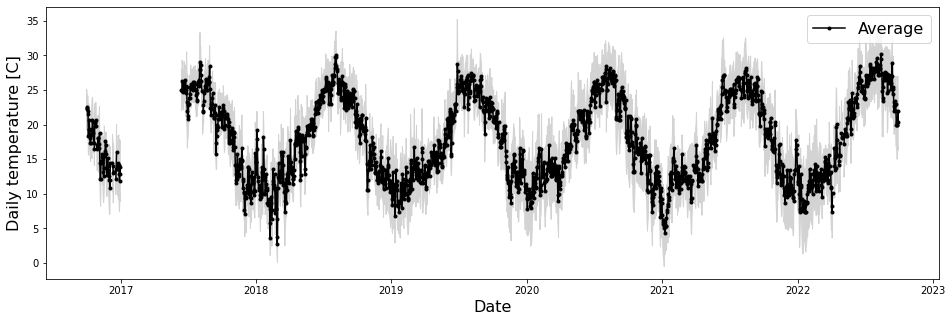

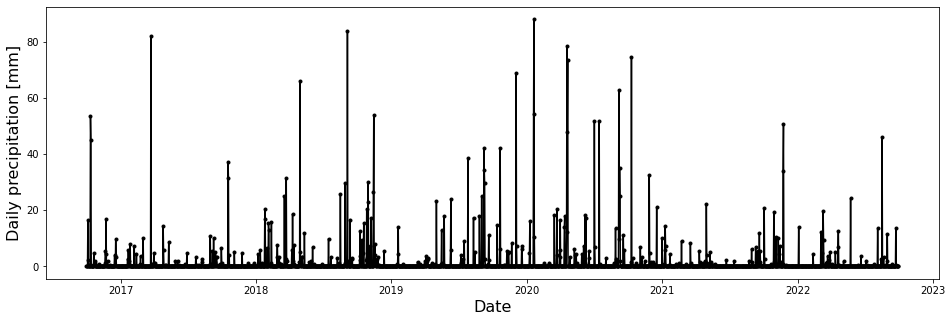

In [15]:
# LEAVE AS-IS

# Retrieve the last 6 years
weather_sample = weather.tail(6*365)

# Plot temperature
plot_min_avg_max(weather_sample)

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Daily precipitation [mm]")

In the plots above we can see temperature and rainfall during the last six years. 

In both cases we observe seasonality, related with temperature we observe a sinusoid patter that repeats over the years, and below for the rainfall we can see them as the inverted of the temperature. When the temperature falls the probability of rainfall is higher and when the temperature increase the probability of rainfall is lower.

Although, in the rainfall plot we see a decrease in the daily precipitation during last two years probably due to the effect of climate change and their effects on the mediterranean area.

## 1.1 Smooth the series using moving averages

In [16]:
# The original series has strong variations from one day to the next one, so we will smooth the series before using it. 
# Here we will use three smoothing methods.

# First implemented method: Moving average

def moving_average(df, window_size):

    smoothed = pd.DataFrame(columns=df.columns)

    for i in range(len(df)):
        # YOUR CODE HERE

         if i < window_size:
            start = 0
         else:
           start = i - window_size

         smoothed.loc[i] = df.iloc[start:i+1].mean()


    smoothed.set_index(df.index, inplace=True)

    return smoothed

In [17]:
weather.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,NaN,NaN,NaN
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,NaN,NaN,NaN
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,NaN,NaN,NaN
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,NaN,NaN,NaN


In [18]:
# LEAVE AS-IS

window_size = 7

weather_smoothed = moving_average(weather, window_size)

weather_smoothed.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min
date,,,,,,,,,,
2016-07-01,24.100000,0.0000,21.900000,26.300000,99.000000,3.100000,5.800000,NaN,NaN,NaN
2016-07-02,24.350000,0.0000,22.100000,26.650000,56.000000,3.350000,6.650000,NaN,NaN,NaN
2016-07-03,24.033333,0.0000,22.033333,26.066667,44.000000,3.633333,7.400000,NaN,NaN,NaN
2016-07-04,23.975000,0.0000,21.975000,26.025000,39.250000,3.550000,7.225000,NaN,NaN,NaN
2016-07-05,24.240000,0.0000,22.220000,26.300000,38.400000,3.460000,7.060000,NaN,NaN,NaN
2016-07-06,24.500000,0.0000,22.366667,26.666667,35.333333,3.716667,7.833333,NaN,NaN,NaN
2016-07-07,24.628571,0.0000,22.557143,26.728571,44.428571,3.742857,8.185714,NaN,NaN,NaN
2016-07-08,24.825000,0.0125,22.737500,26.937500,41.750000,3.587500,8.487500,NaN,NaN,NaN
2016-07-09,25.137500,0.0125,23.100000,27.212500,31.625000,3.587500,8.600000,NaN,NaN,NaN


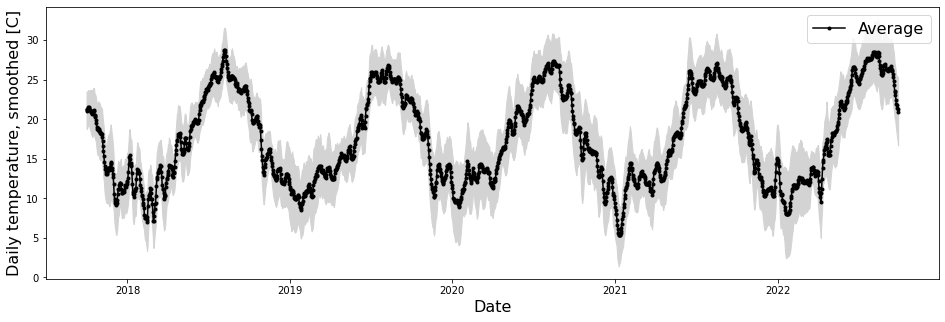

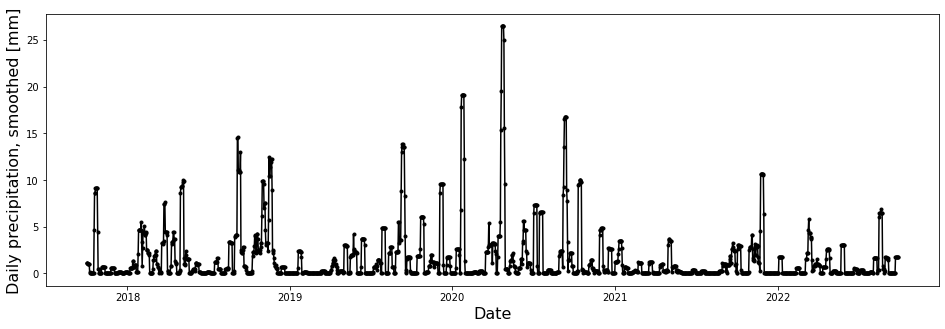

In [19]:
# LEAVE AS-IS

# Sample last 5 years
weather_smoothed_sample = weather_smoothed.tail(5*365)

# Plot smoothed temperature
plot_min_avg_max(weather_smoothed_sample, ylabel='Daily temperature, smoothed [C]')

# Plot smoothed precipitation
plot(weather_smoothed_sample, "rainfall", ylabel="Daily precipitation, smoothed [mm]")


The key difficulties would be the availability of information: we can only start computing the average, after the last timestamp of the window is available, and because of boundary effects we lose some points at the beginning. Also when implementing moving average we are introducing some lags into our analysis that sometimes can make downtrends where there should be peaks and viceversa and make us interpret wrongly the recent trends.


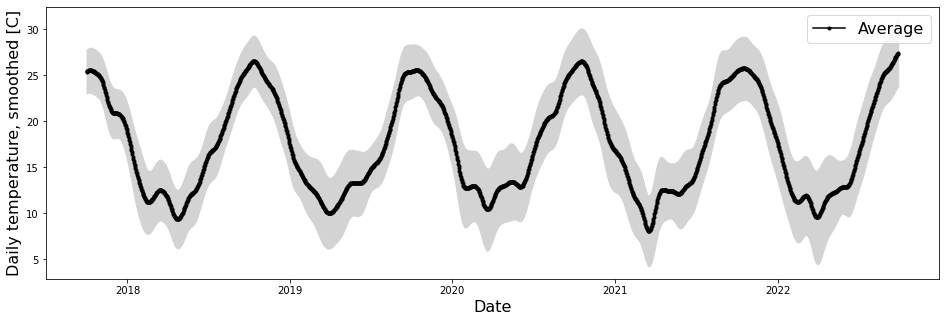

In [20]:
# Test what happens if you repeat the moving average process many times.
test = weather.copy()

for i in range(20): test = moving_average(test, window_size)
    
plot_min_avg_max(test.tail(5*365), ylabel='Daily temperature, smoothed [C]')

Because we have continuously smoothed the dataset, we have removed the short-term fluctuations up to a point where they have almost disappeared. Therefore we only obtain the average trend of temperature throughout the year. However, this might not be ideal because we are losing some information that could be useful for detecting outliers.

## 1.2. Smooth the series by binning per floating weeks

In [21]:
# First, we build a list of weeks that starts with the first day of the studied period and then adds one week until passing over the last day of the studied period.
def list_of_floating_week_starts(first_day, last_day):
    weeks = []

    # YOUR CODE
    t = first_day

    while t < last_day:
        weeks.append(t)
        t += datetime.timedelta(weeks=1)
    weeks.append(t)
    return weeks

In [22]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
weeks = list_of_floating_week_starts(first_day, last_day)

print("There are %d week starts" % len(weeks))
print("First week starts %s, last week starts %s" % (weeks[0].strftime("%Y-%m-%d"), weeks[-1].strftime("%Y-%m-%d")))

There are 327 week starts
First week starts 2016-07-01, last week starts 2022-09-30


In [23]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_week_start= {}
week_num = 0
for date, row in weather.iterrows():
    while not (date >= weeks[week_num] and date < weeks[week_num+1]):
        week_num += 1
    date_to_week_start[date] = weeks[week_num]
    
# Create a new dataframe with an extra column
weather_with_week_start = weather
weather_with_week_start['week_start'] = [date_to_week_start[date] for date in weather.index]
weather_with_week_start.head(10)

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start
date,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01
2016-07-06,25.8,0.0,23.1,28.5,20.0,5.0,11.7,NaN,NaN,NaN,2016-07-01
2016-07-07,25.4,0.0,23.7,27.1,99.0,3.9,10.3,NaN,NaN,NaN,2016-07-01
2016-07-08,26.2,0.1,24.0,28.4,23.0,2.5,10.6,NaN,NaN,NaN,2016-07-08
2016-07-09,26.6,0.0,24.8,28.5,18.0,3.1,6.7,NaN,NaN,NaN,2016-07-08


In [24]:
# Third, we create a new dataframe with the average temperature (min, avg, max), and the total rainfall per floating week.

agg_dict = {}

for key in list(weather.filter(regex='temp_')):
  agg_dict[key] = ['mean']

agg_dict['rainfall'] = ['sum']

weather_per_floating_week = weather_with_week_start.groupby(['week_start']).agg(agg_dict)

weather_per_floating_week.columns = weather_per_floating_week.columns.droplevel(1)

weather_per_floating_week.head(10)

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-07-01,24.628571,22.557143,26.728571,0.0
2016-07-08,25.314286,23.128571,27.500000,0.4
2016-07-15,24.171429,21.485714,26.871429,0.6
2016-07-22,25.428571,22.542857,28.328571,5.8
2016-07-29,25.957143,24.028571,27.871429,0.6
2016-08-05,24.240000,22.240000,26.280000,0.1
2016-08-12,24.800000,22.300000,27.328571,0.0
2016-08-19,25.260000,22.460000,28.080000,0.0
2016-08-26,25.200000,22.785714,27.585714,8.0


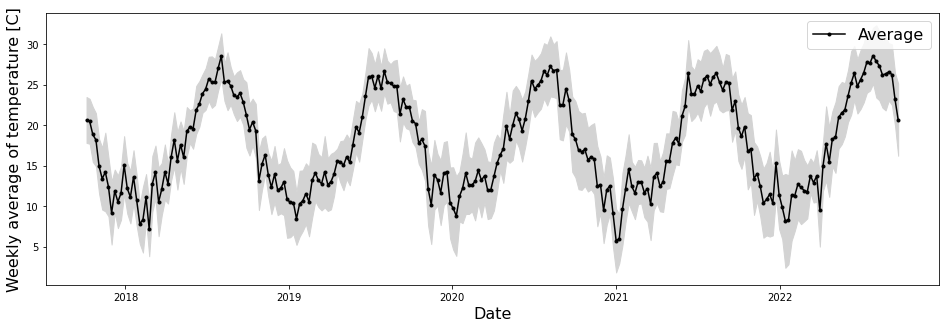

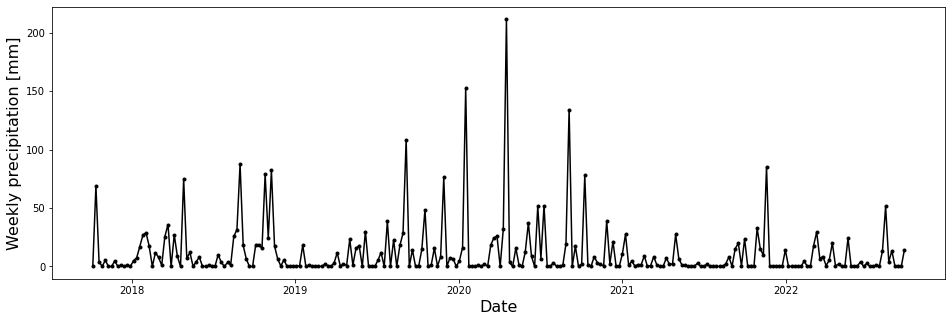

In [25]:
# LEAVE AS-IS

# Retrieve the past 5 years
weather_sample = weather_per_floating_week.tail(5*52)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Weekly average of temperature [C]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Weekly precipitation [mm]")

## 1.3. Smooth the series by binning per month

In [26]:
# Now we repeat the process for months instead of weeks. Now, however, we want to align with the beginning of a calendar month.
# 
# Create the function list_of_month_starts(first, last). It should return an array containing entries of the form Year-Month-01, 
# that is the first of every month. It should start with the first of the month of the first observation, and end with the first 
# of the month following the last observation.

def list_of_month_starts(first_day, last_day):
    months = []
    D = first_day.replace(day = 1)
    
    while D <= last_day.replace(day=1):
        months.append(D)
        
        if D.month < 12:
            D = D.replace(month = D.month+1)
        elif D.month == 12:
            D = D.replace(year=D.year+1, month=1)
        
    months.append(D)
    return months

In [27]:
# LEAVE AS-IS

first_day = np.min(weather.index)
last_day = np.max(weather.index)
months = list_of_month_starts(first_day, last_day)

print("There are %d month starts" % len(months))
print("First month starts %s, last month starts %s" % (months[0].strftime("%Y-%m-%d"), months[-1].strftime("%Y-%m-%d")))

There are 76 month starts
First month starts 2016-07-01, last month starts 2022-10-01


In [28]:
# LEAVE AS-IS

# Create a map from dates to week starts
date_to_month_start= {}
month_num = 0
for date, row in weather.iterrows():
    while not (date >= months[month_num] and date < months[month_num+1]):
        month_num += 1
    date_to_month_start[date] = months[month_num]
    
# Create a new dataframe with an extra column
weather_with_month_start = weather
weather_with_month_start['month_start'] = [date_to_month_start[date] for date in weather.index]
weather_with_month_start

,temp_avg,rainfall,temp_min,temp_max,windspeed_dir,windspeed_avg,windspeed_gusts,sun,pressure_max,pressure_min,week_start,month_start
date,,,,,,,,,,,,
2016-07-01,24.1,0.0,21.9,26.3,99.0,3.1,5.8,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-02,24.6,0.0,22.3,27.0,13.0,3.6,7.5,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-03,23.4,0.0,21.9,24.9,20.0,4.2,8.9,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-04,23.8,0.0,21.8,25.9,25.0,3.3,6.7,NaN,NaN,NaN,2016-07-01,2016-07-01
2016-07-05,25.3,0.0,23.2,27.4,35.0,3.1,6.4,NaN,NaN,NaN,2016-07-01,2016-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-25,20.0,0.0,16.4,23.7,1.0,4.2,8.9,5.9,1013.3,1011.5,2022-09-23,2022-09-01
2022-09-26,20.3,0.0,15.0,25.6,25.0,5.6,13.3,9.7,1012.7,1009.7,2022-09-23,2022-09-01
2022-09-27,20.0,0.0,15.3,24.7,35.0,3.3,8.9,8.2,1011.5,1008.8,2022-09-23,2022-09-01


In [29]:
# Third, we create a new dataframe with the average temperature (min, avg, max), and the total rainfall per  month.

agg_dict = {}

for key in list(weather.filter(regex='temp_')):
  agg_dict[key] = ['mean']

agg_dict['rainfall'] = ['sum']

weather_per_month = weather_with_month_start.groupby(['week_start']).agg(agg_dict)

weather_per_month.columns = weather_per_month.columns.droplevel(1)

weather_per_month.head(10)

,temp_avg,temp_min,temp_max,rainfall
week_start,,,,
2016-07-01,24.628571,22.557143,26.728571,0.0
2016-07-08,25.314286,23.128571,27.500000,0.4
2016-07-15,24.171429,21.485714,26.871429,0.6
2016-07-22,25.428571,22.542857,28.328571,5.8
2016-07-29,25.957143,24.028571,27.871429,0.6
2016-08-05,24.240000,22.240000,26.280000,0.1
2016-08-12,24.800000,22.300000,27.328571,0.0
2016-08-19,25.260000,22.460000,28.080000,0.0
2016-08-26,25.200000,22.785714,27.585714,8.0


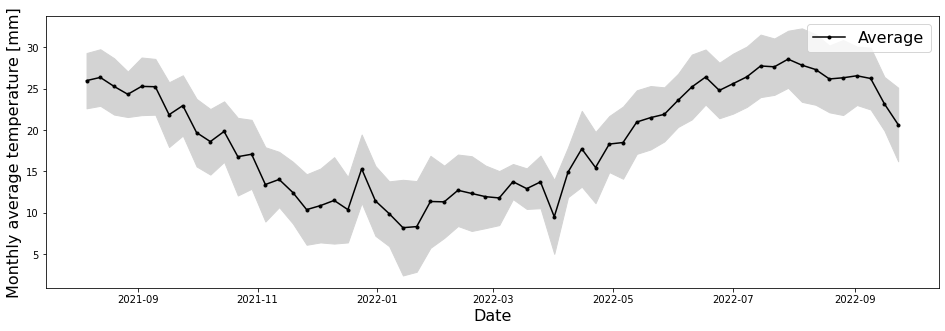

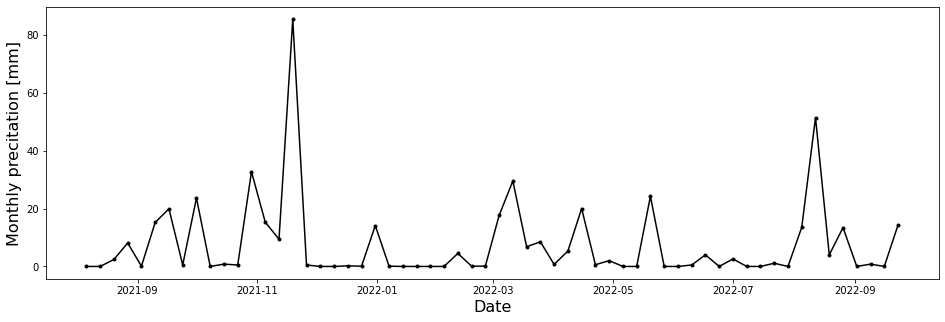

In [30]:
# LEAVE AS-IS

# Retrieve the last 5 years
weather_sample = weather_per_month.tail(5*12)

# Plot temperature
plot_min_avg_max(weather_sample, ylabel="Monthly average temperature [mm]")

# Plot precipitation
plot(weather_sample, "rainfall", ylabel="Monthly precitation [mm]")

Now given that the size of the bins is of 30 days,we are taking each month and computing its average in terms of temperature and rainfall. 

Similar to the daily and weekly graph, we observe seasonality for temperature, meanwhile we dont for rainfall.

# 2. Perform forecasting

## 2.1. Compute auto-correlation plots

In [31]:
# We will start by computing auto-correlation plots, which show to what extent a series is correlated 
# with itself if we consider a certain lag, or time difference.

# The function lagged_series returns the original series trimmed so it is the same length of the lagged series, 
# and the lagged series computed by looking at lag periods in the past. 

def lagged_series(series, lag):
    original_trimmed = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        # YOUR CODE HERE
        # You have to append series[i] to original and series[j] to lagged
        # but only if j is in [0, len(series)-1]

        if j>= 0 and j <= len(series) - 1:
            lagged.append(series[j])
            original_trimmed.append(series[i])


    return original_trimmed, lagged

In [32]:
# LEAVE AS-IS

assert ([44, 55, 66, 77, 88], [11, 22, 33, 44, 55]) == lagged_series([11,22,33,44,55,66,77,88], 3)

assert ([33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66]) == lagged_series([11,22,33,44,55,66,77,88], 2)

assert ([22, 33, 44, 55, 66, 77, 88], [11, 22, 33, 44, 55, 66, 77]) == lagged_series([11,22,33,44,55,66,77,88], 1)


In [33]:
# LEAVE AS-IS

# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  

# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)

In [34]:
# Now we will create auto-correlation plots. Creation of a function compute_autocorrelations(series, max_periods) 
# that returns all the auto-correlations of a series from period 0 to max_periods-1.

def compute_autocorrelations(series, max_periods):
    return [ autocorrelation(series, i) for i in range(max_periods) ]

In [35]:
max_periods = 2*365
auto_correlations_temp = compute_autocorrelations(weather['temp_avg'], max_periods)
auto_correlations_rainfall = compute_autocorrelations(weather['rainfall'], max_periods)

In [36]:
# LEAVE AS-IS

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation"):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

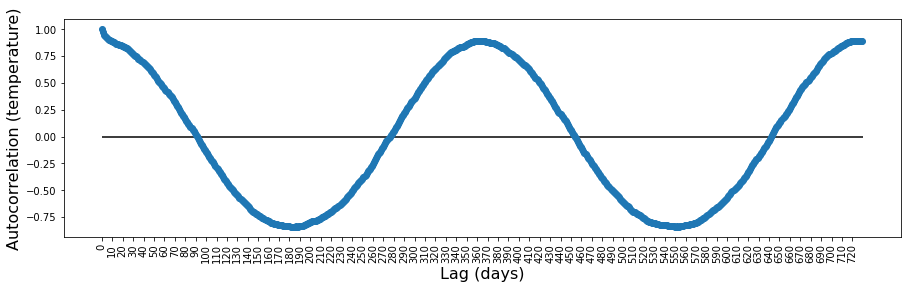

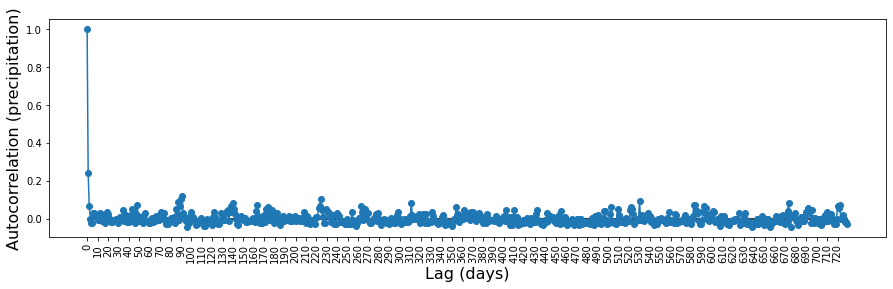

In [37]:
# LEAVE AS-IS

# Plot temperature auto-correlation
plot_auto_correlations(auto_correlations_temp, ylabel="Autocorrelation (temperature)")

# Plot precipitation auto-correlation
plot_auto_correlations(auto_correlations_rainfall, ylabel="Autocorrelation (precipitation)")

Here we can see a sinusoidal pattern for the temperature, but for the rainfall it seems very random.

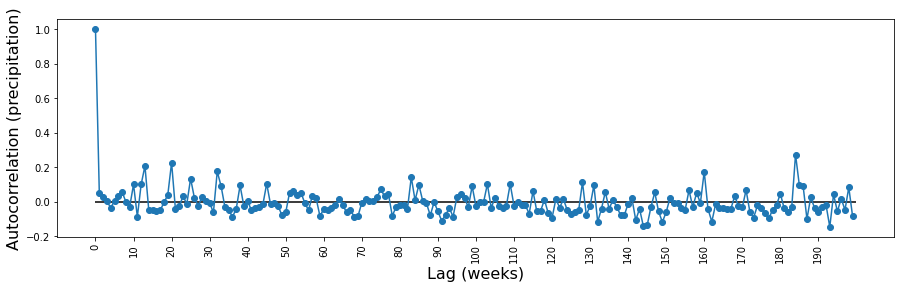

In [38]:
# LEAVE AS-IS

auto_correlations_rainfall_week = compute_autocorrelations(weather_per_floating_week['rainfall'], 200)

plot_auto_correlations(auto_correlations_rainfall_week, xlabel='Lag (weeks)', ylabel="Autocorrelation (precipitation)")

This correlations may be spurious, this is because it doesn't matter if it rains during a certain week that it wont make it more probable to rain another week in specific.

## 2.2. Prepare a system of equations to learn an auto-regressive model

In [39]:
def prepare_matrices(series, lags):
    y = []
    X = []

    for lag in lags:
        assert(lag > 0)
        assert(lag < len(series))
        

    for i in range(np.max(lags), len(series)):
        # YOUR CODE HERE
        right = series[i-lags[0]]
        left = series[i-lags[1]]
        if (not math.isnan(right)) and (not math.isnan(left)) and (not math.isnan(series[i])):
            row = [right, left]
            X.append(row)
            y.append(series[i])

    return X, y

Test your code. Given the series `[11, 19, 32, 38, 51, 58, 69, 81]` and lags `[2, 3]`, you should obtain:

```
X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [40]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, 38, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[19, 11], [32, 19], [38, 32], [51, 38], [58, 51]]
y=[38, 51, 58, 69, 81]


In [41]:
# LEAVE AS-IS

X, y = prepare_matrices([11, 19, 32, np.nan, 51, 58, 69, 81], [2, 3])
print("X=%s" % X)
print("y=%s" % y)

X=[[32, 19], [58, 51]]
y=[51, 81]


## 2.3. Perform forecasts

In [42]:
# LEAVE AS-IS

def perform_forecast(series, lags):

    # Prepare matrices for linear regression
    X, y = prepare_matrices(series, lags)

    # Perform forecast
    linear_regressor = LinearRegression()
    linear_regressor.fit(X,y)
    y_pred = linear_regressor.predict(X)

    # Compute forecasting error
    # Root mean squared error, normalized
    rmse = math.sqrt(mean_squared_error(y, y_pred))/(np.max(y)-np.min(y))
    
    # Return: observed, predicted, error
    return (y, y_pred, rmse)

def plot_forecast(y, y_pred, xlabel="Period", ylabel="", nrmsd=-1):

    plt.figure(figsize=(15,4))
    
    plt.plot(y, '.-', linewidth=4, color='gray', label='Observed')
    plt.plot(y_pred, '--', linewidth=2, color='green', label=('Model (NRMSD=%.2f)' % nrmsd if nrmsd > 0 else 'Model'))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()

In [43]:
lags_monthly_temperature = [5,12,18,23]

# Each leg can be between [1, 325]

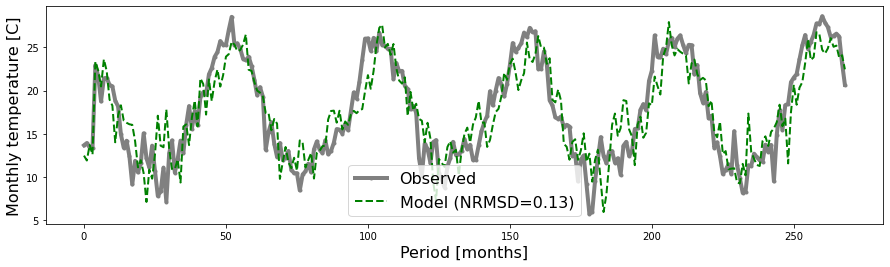

In [44]:
# LEAVE AS-IS

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['temp_avg'], lags_monthly_temperature)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly temperature [C]", nrmsd=nrmsd)

In [45]:
lags_weekly_temperature = [26,52,78,104]
# Each leg can be between [1, 325]

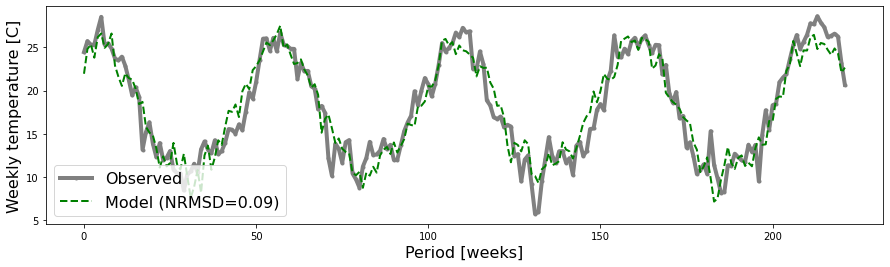

In [46]:
# LEAVE AS-IS

(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['temp_avg'], lags_weekly_temperature)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly temperature [C]", nrmsd=nrmsd)

In [47]:
lags_daily_temperature = [183,365,547,730]

# Each leg can be between [1, 2279]

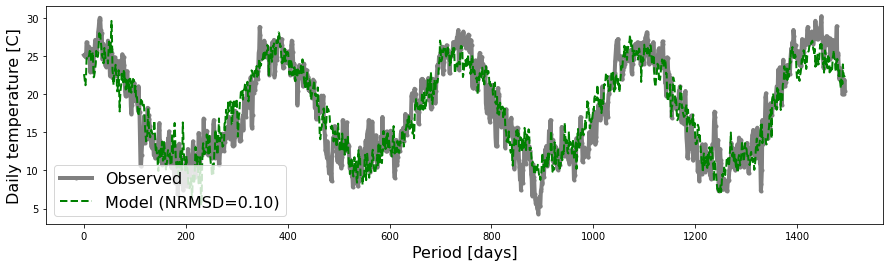

In [48]:
# Leave this code as-is

(y, y_pred, nrmsd) = perform_forecast(weather['temp_avg'], lags_daily_temperature)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily temperature [C]", nrmsd=nrmsd)

As explained before, the temperature acts like a sinusoid. This is why we can perform forecasts based on the previous values of temperature

In [49]:
lags_monthly_rainfall = [1,4,7,10]

# Each leg can be between [1, 325]

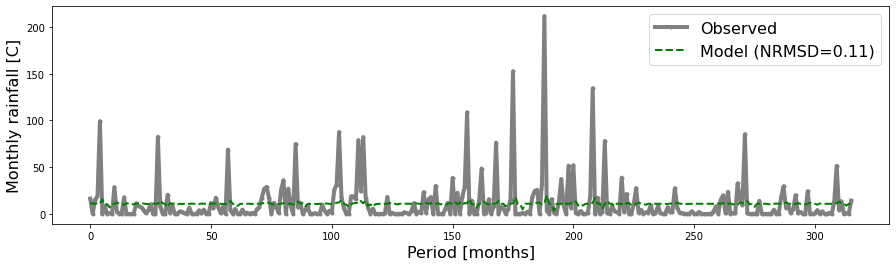

In [50]:
# Leave this code as-is

(y, y_pred, nrmsd) = perform_forecast(weather_per_month['rainfall'], lags_monthly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [months]", ylabel="Monthly rainfall [C]", nrmsd=nrmsd)

In [51]:
lags_weekly_rainfall = [26,52,78,104]

# Each leg can be between [1, 325]

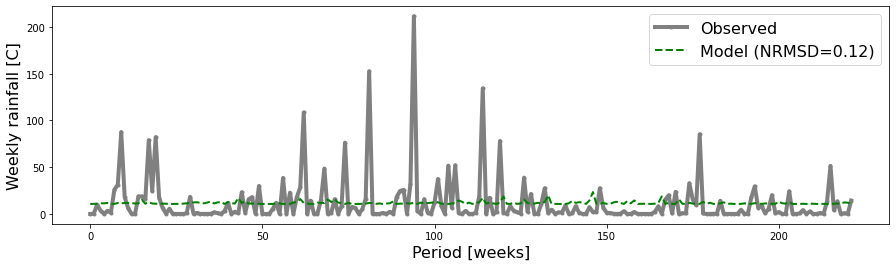

In [52]:
# Leave this code as-is

(y, y_pred, nrmsd) = perform_forecast(weather_per_floating_week['rainfall'], lags_weekly_rainfall)
plot_forecast(y, y_pred, xlabel="Period [weeks]", ylabel="Weekly rainfall [C]", nrmsd=nrmsd)

In [53]:
lags_daily_rainfall = [183,365,547,730]

# Each leg can be between [1, 2279]

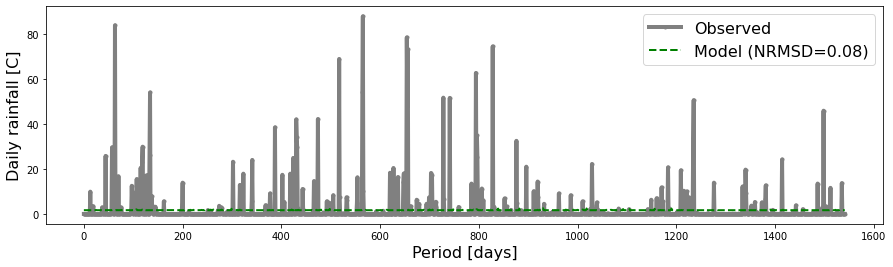

In [54]:
# Leave this code as-is

(y, y_pred, nrmsd) = perform_forecast(weather['rainfall'], lags_daily_rainfall)
plot_forecast(y, y_pred, xlabel="Period [days]", ylabel="Daily rainfall [C]", nrmsd=nrmsd)

For rainfall, there's no set pattern that helps us predict the values using the values happened before. 